In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_value = calc_temps('2011-01-01', '2011-12-31')
for ymin,yavg,ymax in year_value:
    print(f"The minimum temperature for a year is: {ymin}")
    print(f"The average temperature for a year is: {yavg}")
    print(f"The maximum temperature for a year is: {ymax}")

The minimum temperature for a year is: 56.0
The average temperature for a year is: 72.67471642883278
The maximum temperature for a year is: 86.0


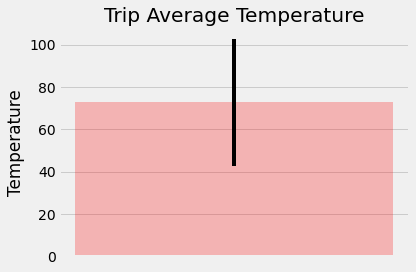

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
all_values = list(np.ravel(year_value))
tmin = all_values[0]
tavg = all_values[1]
tmax = all_values[2]
std = tmax-tmin
means=tavg
positions = 0
width = 0.15
xticks = []
plt.bar(positions,means, width, color="r",alpha = 0.25,yerr=std)
plt.title("Trip Average Temperature")
plt.ylabel('Temperature')
plt.xticks(xticks)

plt.tight_layout()
plt.savefig("Images/temperature.png")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rain = session.query(Measurement.station,func.sum(Measurement.prcp).label("total_rain"), Station.name,\
                            Station.latitude,Station.longitude,Station.elevation).\
                filter(Measurement.station == Station.station).\
                group_by(Measurement.station).order_by(desc("total_rain")).all()

rainfall_dict = [r._asdict() for r in station_rain]

rainfall_df = pd.DataFrame(rainfall_dict)
rainfall_df

,station,total_rain,name,latitude,longitude,elevation
0,USC00516128,1068.09,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,588.64,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,382.62,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,295.68,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,234.49,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,131.62,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00511918,92.68,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00518838,70.87,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
8,USC00517948,43.44,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_date_range = pd.date_range(start_date, end_date).tolist()

# Strip off the year and save a list of strings in the format %m-%d
trip_date = []
for d in trip_date_range:
    trip_date.append(d.strftime("%m-%d"))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for s in trip_date:
    result = daily_normals(s)
    for tmin, tavg, tmax in result:
        trip_dict = {}
        trip_dict["tmin"] = tmin
        trip_dict["tavg"] = tavg
        trip_dict["tmax"] = tmax
        normals.append(trip_dict)

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals) 
trip_df['trip_dates'] = trip_date
trip_indexed_df = trip_df.set_index('trip_dates',drop = True)
trip_indexed_df

,tmin,tavg,tmax
trip_dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


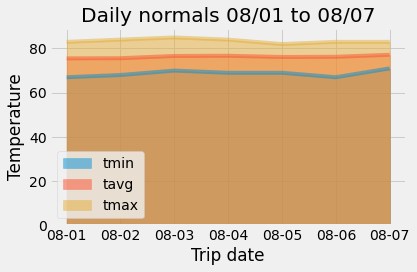

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_indexed_df.plot.area(stacked=False)
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip date")
ax.set_title("Daily normals 08/01 to 08/07")

plt.tight_layout()
plt.savefig("Images/dailynormals.png")
plt.show()

## Close Session

In [17]:
session.close()